<a href="https://colab.research.google.com/github/KunalSachdev2005/Data_Science_Intern_at_Info_Origin/blob/main/BBC_News_Articles_Classification_RoBERTa_with_Enriched_Vocab_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BBC News Articles Classification - RoBERTa with Enriched Vocabulary Layer**

## Dataset Source

https://www.kaggle.com/datasets/moazeldsokyx/bbc-news/data

## Importing the Required Libraries

In [ ]:
from google.colab import drive # Mounting Notebook on Google Drive to access files
drive.mount('/content/drive', force_remount = True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
from torch import nn
from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install accelerate -U

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install transformers[torch]

## Reading the Data

In [ ]:
bbc_df = pd.read_csv("/content/drive/MyDrive/Task_9/bbc-text.csv")

In [ ]:
bbc_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
bbc_df.shape

(2225, 2)

In [ ]:
bbc_df.dtypes

category    object
text        object
dtype: object

## Exploratory Data Aanalysis

### Checking for Missing Values

In [ ]:
bbc_df.isnull().sum()

category    0
text        0
dtype: int64

**There are no missing values in the dataset**

### Class Distribution

In [ ]:
bbc_df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<ipython-input-10-11c972a08e49>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  class_dist = sns.countplot(x='category', data=bbc_df, palette='pastel')


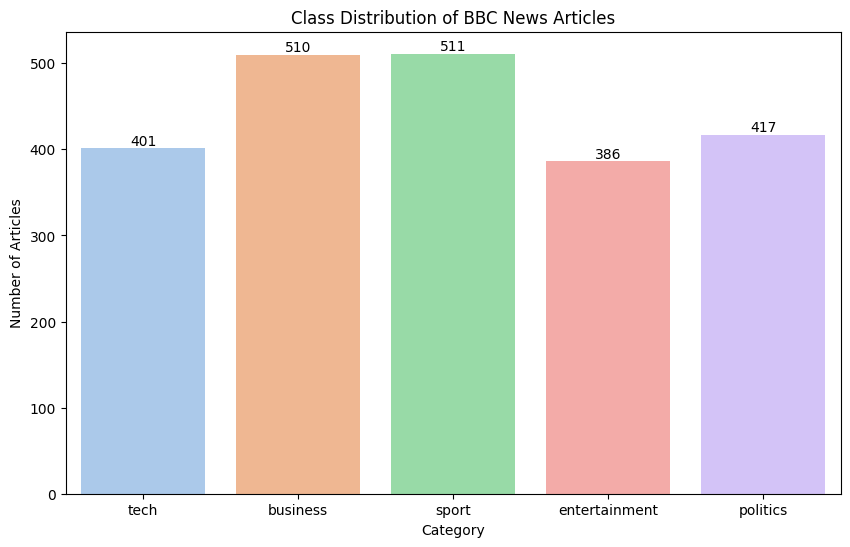

In [ ]:
plt.figure(figsize=(10,6))
class_dist = sns.countplot(x='category', data=bbc_df, palette='pastel')
plt.title('Class Distribution of BBC News Articles')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
for p in class_dist.patches:
    class_dist.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center',
                        xytext = (0, 5),
                        textcoords = 'offset points')
#plt.savefig("bbc_news/class_distribution.png")
plt.show()

**The classes are relatively evenly distributed.**

### Text Length Distribution

In [ ]:
bbc_df['text_length'] = bbc_df['text'].apply(lambda x: len(x.split()))

In [ ]:
bbc_df.head()

,category,text,text_length
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260


In [ ]:
bbc_df.describe()

,text_length
count,2225.000000
mean,390.295281
std,241.753128
min,90.000000
25%,250.000000
50%,337.000000
75%,479.000000
max,4492.000000


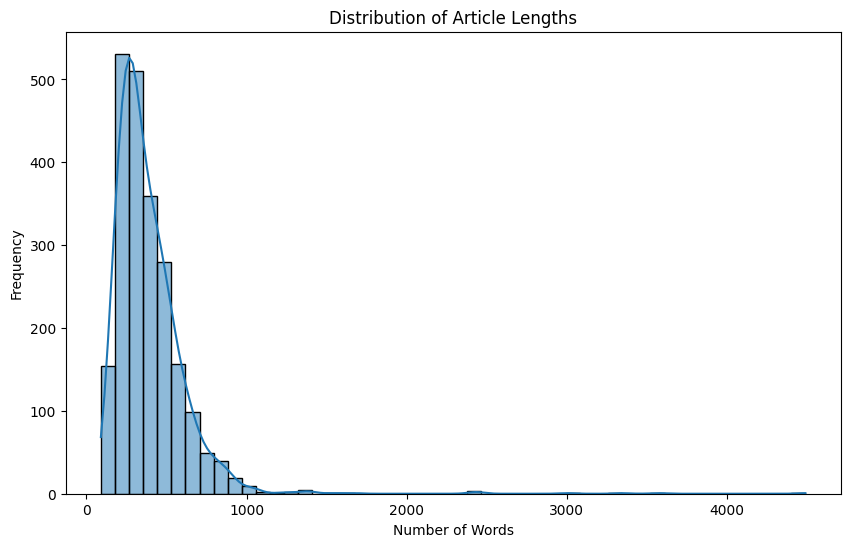

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(bbc_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
#plt.savefig("bbc_news/article_lengths")
plt.show()

**There is variation in text length of the news articles in the data set, with an average length of approximately 390 words. The length of the news articles ranges from 90 to 4,492 words, indicating that some articles are much longer than others.**

### Most Frequent Words in the Articles By Class

#### Before Preprocessing

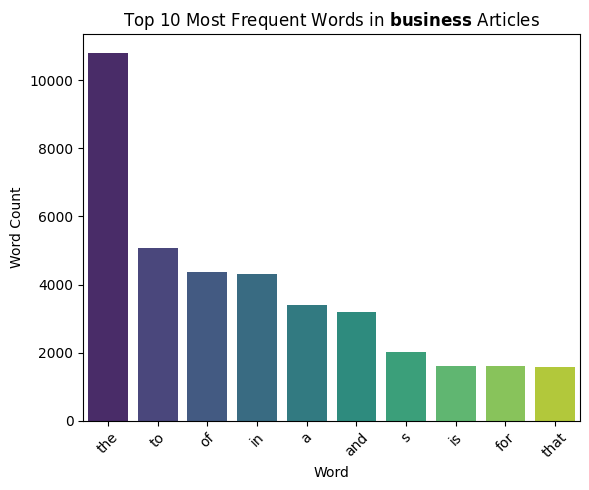

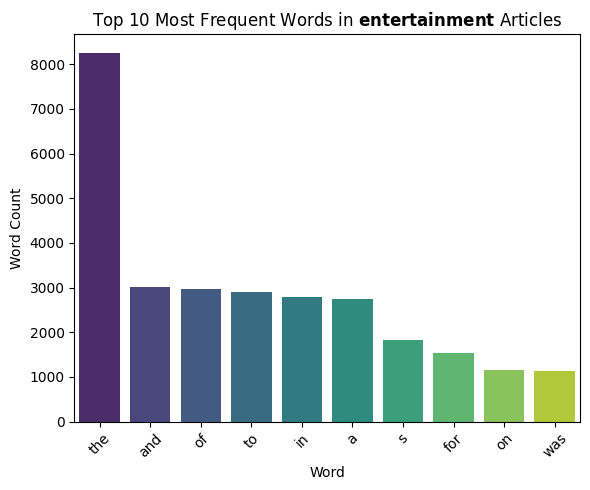

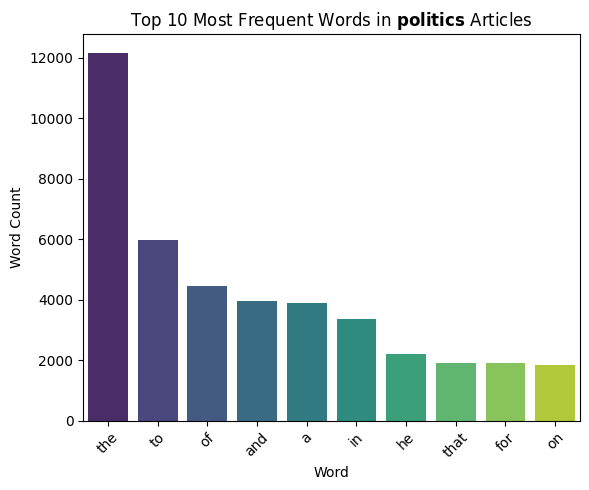

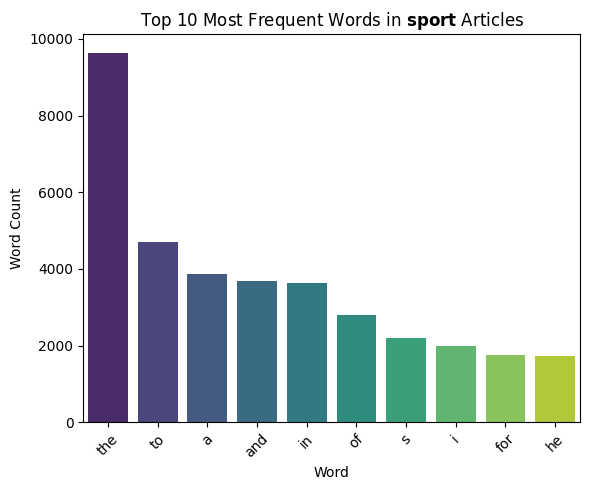

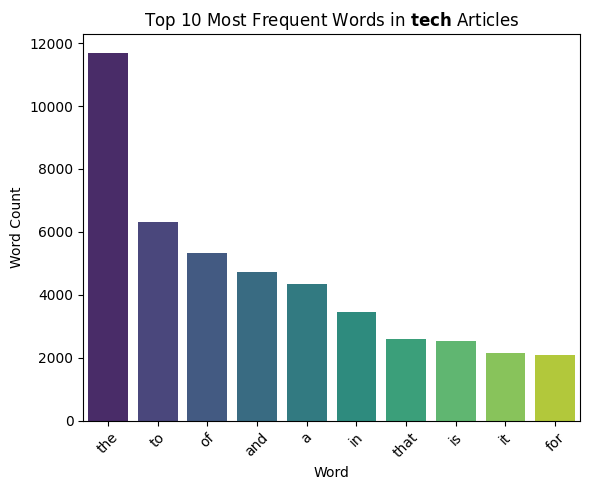

In [ ]:
def get_most_freq_words(df, col, preprocessing = False):

    most_freq_words_by_class = {} # Dictionary Structure {'category1': {'word1': freq1, 'word2': freq2, ...}, 'category2': ...}

    grouped_data = df.groupby('category') # Grouping articles by category

    for category, group_df in grouped_data:

        all_articles = ' '.join(group_df[col])
        words = all_articles.split()
        no_of_words = Counter(words)
        most_freq_words = dict(no_of_words.most_common(10))
        most_freq_words_by_class[category] = most_freq_words

    for category, most_freq_words in most_freq_words_by_class.items(): # Constructing the bar charts for each category of articles

        most_freq_words_df = pd.DataFrame({'Word':list(most_freq_words.keys()), 'Count': list(most_freq_words.values())})

        plt.figure(figsize=(6, 5))

        if preprocessing:
          most_freq_words_by_class_dist = sns.barplot(x='Word', y='Count', data=most_freq_words_df, palette='viridis', hue='Word', dodge = False)
          plt.title(f'Top 10 Most Frequent Words in \n $\mathbf{{Preprocessed\ {category}}}$ Articles', fontsize=16)
          plt.xlabel('Word')
          plt.ylabel('Word Count')
          plt.xticks(rotation=45) # Rotating the x labels to avoid overlapping
          plt.tight_layout()
          plt.legend().remove() # Removing legend because it does not provide any additional information
          #plt.savefig(f'bbc_news/top_10_words_Preprocessed_{category}.png') # Saving the plot
          plt.show()


        else:
          most_freq_words_by_class_dist = sns.barplot(x='Word', y='Count', data=most_freq_words_df, palette='viridis', hue='Word', dodge = False)
          plt.title(f'Top 10 Most Frequent Words in $\mathbf{{{category}}}$ Articles')
          plt.xlabel('Word')
          plt.ylabel('Word Count')
          plt.xticks(rotation=45)
          plt.tight_layout()
          plt.legend().remove()
          #plt.savefig(f'bbc_news/top_10_words_{category}.png')
          plt.show()

# Calling the function before Preprocessing
get_most_freq_words(bbc_df, 'text', preprocessing = False)

**We see that before preprocessing words like "the", "to", "and", "of", "in", "a", etc. are the most used words across all article categories. This however does not provide us with any valuable information. Let's handle these words and then check the most used words again.**

## Preprocessing

**Stop words are a collection of very common words that are important for sentence structure but carry very little meaning on their own.**

**This includes words like "the", "an", "a", "and", "on", "with", "in", "from", "with", "at", etc. (a full list can be found below)**


In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocessor(text):

    text = text.lower() # Converting to lower case
    words = word_tokenize(text) # splitting into tokens, handling punctuation, contractions and hyphenated words
    filtered_words = [word for word in words if word not in stop_words and word not in punctuation]

    return ' '.join(filtered_words)

bbc_df['text_processed'] = bbc_df['text'].apply(preprocessor)

bbc_df

,category,text,text_length,text_processed
0,tech,tv future in the hands of viewers with home th...,737,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean twelve raids box office ocean twelve cri...
...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,293,cars pull us retail figures us retail sales fe...
2221,politics,kilroy unveils immigration policy ex-chatshow ...,156,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...,301,rem announce new glasgow concert us band rem a...
2223,politics,how political squabbles snowball it s become c...,858,political squabbles snowball become commonplac...


#### After Preprocessing

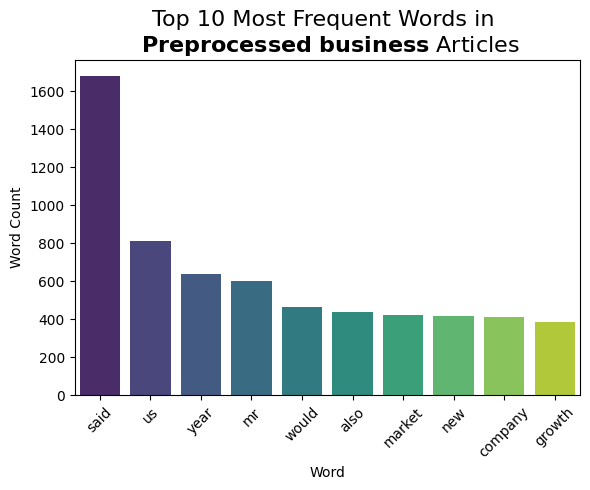

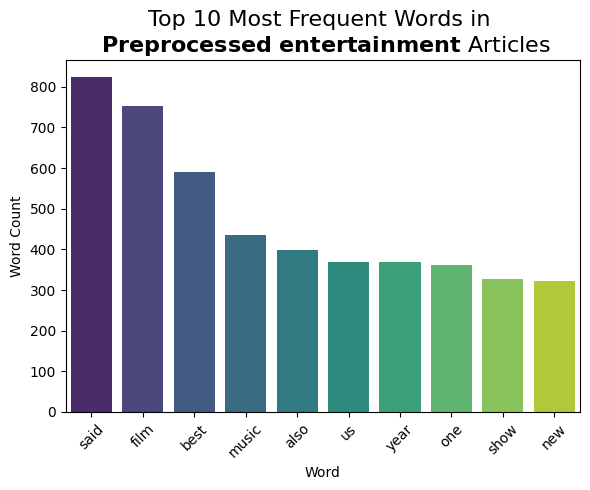

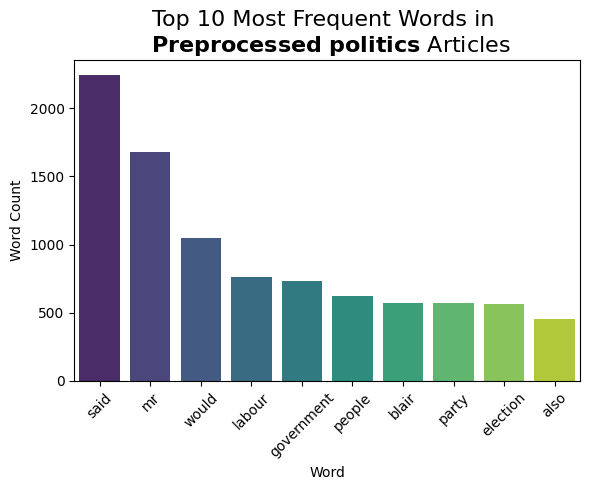

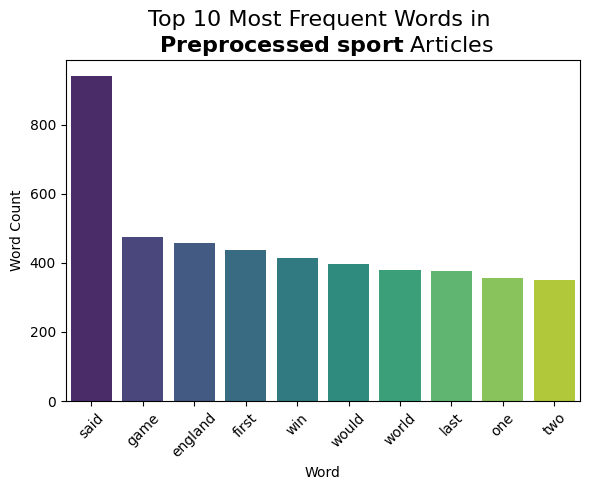

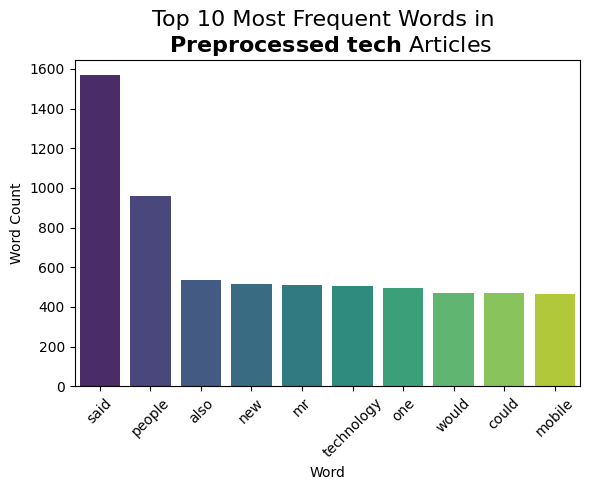

In [ ]:
get_most_freq_words(bbc_df, 'text_processed', preprocessing = True)

**Take, for example, business articles. Now we see that words like "year", "market", "company", and "growth" are some of the most used words.**

**Thus, preprocessing the articles allowed us to get a deeper understanding of the articles, which will also help our model make better predictions.**

### Encoding

Converting the news categories in the data set to numerical values

In [ ]:
labelencoder = LabelEncoder()
bbc_df['numeric_classes'] = labelencoder.fit_transform(bbc_df['category'])

In [ ]:
df_labels = pd.DataFrame({
    'Category': bbc_df['category'].unique(),
    'Corresponding Number': bbc_df['numeric_classes'].unique()
})
df_labels = df_labels.sort_values(by='Corresponding Number', ascending=True)
df_labels

,Category,Corresponding Number
1,business,0
3,entertainment,1
4,politics,2
2,sport,3
0,tech,4


### Stemming and Lemmatization



Stemming & Lemmatization are techniques to **reduce words to their base form.**

*   Stemming is a more aggresive approach. It **chops off suffixes from words based on a set of rules** and might **not always lead to valid words**.
*   Players -> Play; Running -> Run; Beaty -> Beaut (not a real word, not helpful)

*   Lemmatization uses a dictionary and morphological analysis to map a word to its dictionary base form (lemma).
*   Running -> Run (correct base form), Beautiful -> Beautiful (already in base form).

**Lemmatization tends to be slower but more accurate and will always convert to a real word (lemma) unlike stemming.**



In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stemming function
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

# Lemmatization function
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

# Apply stemming
bbc_df['text_stemmed'] = bbc_df['text_processed'].apply(stem_text)

# Apply lemmatization
bbc_df['text_lemmatized'] = bbc_df['text_processed'].apply(lemmatize_text)

# Applying both simultaneously
bbc_df['text_stem_lem'] = bbc_df['text_lemmatized'].apply(stem_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
bbc_df.head()

,category,text,text_length,text_processed,numeric_classes,text_stemmed,text_lemmatized,text_stem_lem
0,tech,tv future in the hands of viewers with home th...,737,tv future hands viewers home theatre systems p...,4,tv futur hand viewer home theatr system plasma...,tv future hand viewer home theatre system plas...,tv futur hand viewer home theatr system plasma...
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldcom...,0,worldcom boss left book alon former worldcom b...,worldcom bos left book alone former worldcom b...,worldcom bo left book alon former worldcom bo ...
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary farrell gamble leicester say rushe...,3,tiger wari farrel gambl leicest say rush make ...,tiger wary farrell gamble leicester say rushed...,tiger wari farrel gambl leicest say rush make ...
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle fa cup premiership side...,3,yead face newcastl fa cup premiership side new...,yeading face newcastle fa cup premiership side...,yead face newcastl fa cup premiership side new...
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean twelve raids box office ocean twelve cri...,1,ocean twelv raid box offic ocean twelv crime c...,ocean twelve raid box office ocean twelve crim...,ocean twelv raid box offic ocean twelv crime c...


In [ ]:
bbc_df.to_csv('/content/drive/MyDrive/Task_9/bbc_df.csv', index = False)

## Train Test Split

In [ ]:
bbc_df = pd.read_csv("/content/drive/MyDrive/BBC_News_Articles_Classification/bbc_df.csv")
bbc_df.head()

,category,text,text_length,text_processed,numeric_classes,text_stemmed,text_lemmatized,text_stem_lem
0,tech,tv future in the hands of viewers with home th...,737,tv future hands viewers home theatre systems p...,4,tv futur hand viewer home theatr system plasma...,tv future hand viewer home theatre system plas...,tv futur hand viewer home theatr system plasma...
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldcom...,0,worldcom boss left book alon former worldcom b...,worldcom bos left book alone former worldcom b...,worldcom bo left book alon former worldcom bo ...
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary farrell gamble leicester say rushe...,3,tiger wari farrel gambl leicest say rush make ...,tiger wary farrell gamble leicester say rushed...,tiger wari farrel gambl leicest say rush make ...
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle fa cup premiership side...,3,yead face newcastl fa cup premiership side new...,yeading face newcastle fa cup premiership side...,yead face newcastl fa cup premiership side new...
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean twelve raids box office ocean twelve cri...,1,ocean twelv raid box offic ocean twelv crime c...,ocean twelve raid box office ocean twelve crim...,ocean twelv raid box offic ocean twelv crime c...


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data set into training and testing sets
# Using 20% of the dataset for testing and rest for training
# stratify allows us have the same proportion of class labels as the input dataset

X_train, X_test, y_train, y_test = train_test_split(bbc_df["text_processed"], bbc_df["numeric_classes"], test_size = 0.2, random_state = 42, stratify = bbc_df['numeric_classes'])

In [ ]:
len(X_train), len(X_test)

(1780, 445)

In [ ]:
y_train.value_counts()

numeric_classes
3    409
0    408
2    333
4    321
1    309
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

numeric_classes
0    102
3    102
2     84
4     80
1     77
Name: count, dtype: int64

## RoBERTa Tokenizer

The Tokenizer converts input text into a format that RoBERTa model can process:

* Converts input sequence to lower case
* Removes or replaces special characters
* Split text into individual tokens (words, sub-words, characters). Follows Byte-Pair Encoding (BPE)
* Adds special tokens like [CLS] and [SEP]
* Padding and Truncation
* Convert tokens to corresponsing numerical IDs based on model's vocabulary
* Attention masks to indicate which tokens the model should attend to - 1 for real tokens and 0 for padding tokens

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_data(text):
    return tokenizer(text.tolist(), padding = True, truncation = True, max_length = 512, return_tensors='pt')
    # Adding padding if text is less than 512 tokens
    # Truncating text if it exceeds length 512
    # Returning PyTorch Tensors for compatibility with PyTorch Modules and efficient batch processing
    # PyTorch Tensors manage memory efficiently, and are optimized for calculations on GPUs
    # Max length is set to 512 because of RoBERTa's model architecture

X_train_encodings = tokenize_data(X_train)
X_test_encodings = tokenize_data(X_test)

y_train_labels = torch.tensor(y_train.values)
y_test_labels = torch.tensor(y_test.values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
type(X_train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
print(X_train_encodings.keys())

dict_keys(['input_ids', 'attention_mask'])


In [ ]:
print(len(X_train_encodings['input_ids']))

1780


In [ ]:
print(y_train_labels.shape)

torch.Size([1780])


In [ ]:
print(len(y_train))

1780


In [ ]:
print(X_train_encodings['input_ids'][0])

tensor([    0, 12689,  2501, 13824,    12,  9591, 14197,   792,  9473,   811,
        15814, 14197,  1507,   458,   907,    12,  1644,  3231,  3038,   476,
         3860, 10568,   284,   907,    12,  1644,  1124,  2243,   475,  1350,
         4891, 13569,  1543,  1060,  1114,  2138,    41,   718,  2626,    12,
        13599,   397,    26, 18998,   907,    12,  1644,  2198,  9458, 10495,
          792,  1991,   517,  7213,   508,  1136, 14197,   327,   187, 13824,
         1059,   285,    94,   353,   138, 38251,  6514,   187,  3787, 19480,
          853,  1792, 30279, 13569,  1543,   962,  5241,  1618,   452,  1062,
         1613,   475,  1350,  4891,  2980,    26, 14770,   967,   910,   658,
         1543,   394,  9473,   811, 18751,  8421,  4840,   857,    12,   805,
         5539,   809,   138,   708,   907,   124,  3135,   153,   327, 22599,
         6365,  9495,   984,   401,     4,  2940,   508, 14871,  4549,   158,
          595,   210,   425,     2,     1,     1,     1,     1, 

In [ ]:
print(X_train_encodings['attention_mask'][0])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Initializing Dataset Class

Dataset class allows organizing the data, performing preprocessing steps, and making it compatible with training algorithms

In [ ]:
class BBCNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = BBCNewsDataset(X_train_encodings, y_train_labels)
test_dataset = BBCNewsDataset(X_test_encodings, y_test_labels)

In [ ]:
print(train_dataset[0])

{'input_ids': tensor([    0, 12689,  2501, 13824,    12,  9591, 14197,   792,  9473,   811,
        15814, 14197,  1507,   458,   907,    12,  1644,  3231,  3038,   476,
         3860, 10568,   284,   907,    12,  1644,  1124,  2243,   475,  1350,
         4891, 13569,  1543,  1060,  1114,  2138,    41,   718,  2626,    12,
        13599,   397,    26, 18998,   907,    12,  1644,  2198,  9458, 10495,
          792,  1991,   517,  7213,   508,  1136, 14197,   327,   187, 13824,
         1059,   285,    94,   353,   138, 38251,  6514,   187,  3787, 19480,
          853,  1792, 30279, 13569,  1543,   962,  5241,  1618,   452,  1062,
         1613,   475,  1350,  4891,  2980,    26, 14770,   967,   910,   658,
         1543,   394,  9473,   811, 18751,  8421,  4840,   857,    12,   805,
         5539,   809,   138,   708,   907,   124,  3135,   153,   327, 22599,
         6365,  9495,   984,   401,     4,  2940,   508, 14871,  4549,   158,
          595,   210,   425,     2,     1,     1, 

## Training & Evaluating RoBERTa Model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = 5)
model = model.to('cuda')

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs'
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)

trainer.train()

results = trainer.evaluate()
print(results)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-cda73e7f9bb7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss
500,0.412100
1000,0.088000


<ipython-input-16-cda73e7f9bb7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-16-cda73e7f9bb7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.11372869461774826, 'eval_runtime': 12.9626, 'eval_samples_per_second': 34.33, 'eval_steps_per_second': 4.32, 'epoch': 5.0}


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_test_labels, preds, target_names=list(bbc_df['category'].value_counts().index))

print(report)

<ipython-input-16-cda73e7f9bb7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


               precision    recall  f1-score   support

        sport       0.95      0.99      0.97       102
     business       0.97      1.00      0.99        77
     politics       1.00      0.96      0.98        84
         tech       1.00      1.00      1.00       102
entertainment       1.00      0.96      0.98        80

     accuracy                           0.98       445
    macro avg       0.99      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [ ]:
trainer.save_model("/content/drive/MyDrive/Task_9/MyRoBERTaModel")

## Defining, Training, Evaluating RoBERTa model with Encoded Vocabulary Layer

In [ ]:
from transformers import RobertaConfig

In [ ]:
class CustomRobertaModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomRobertaModel, self).__init__()
        self.config = RobertaConfig.from_pretrained('roberta-base', output_hidden_states = True)
        self.roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', config = self.config)
        self.encoded_vocab_layer = nn.Linear(self.roberta.config.hidden_size, 128) # Encoded vocabulary layer
        self.final_layer = nn.Linear(128, num_labels)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, attention_mask = attention_mask, output_hidden_states = True)
        hidden_states = outputs.hidden_states[-1]  # Last hidden state
        encoded_vocab_output = self.encoded_vocab_layer(hidden_states[:, 0, :])
        logits = self.final_layer(encoded_vocab_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits}

# Instantiate the model
model = CustomRobertaModel(num_labels = 5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define new training arguments if needed
enhanced_training_args = TrainingArguments(
    output_dir = '/content/drive/MyDrive/BBC_News_Articles_Classification/enhanced_results',
    num_train_epochs = 5,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = '/content/drive/MyDrive/BBC_News_Articles_Classification/enhanced_logs',
    gradient_accumulation_steps = 2
)

# Initialize the enhanced trainer
enhanced_trainer = Trainer(
    model = model,
    args = enhanced_training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
)

# Train the enhanced model
enhanced_trainer.train()

# Evaluate the enhanced model
enhanced_results = enhanced_trainer.evaluate()
print(enhanced_results)

model_save_path = '/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa'
enhanced_trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Step,Training Loss
500,0.420700
1000,0.079000


{'eval_loss': 0.1269454061985016, 'eval_runtime': 15.6466, 'eval_samples_per_second': 28.441, 'eval_steps_per_second': 7.158, 'epoch': 4.98876404494382}


('/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa/tokenizer_config.json',
 '/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa/special_tokens_map.json',
 '/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa/vocab.json',
 '/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa/merges.txt',
 '/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa/added_tokens.json')

In [ ]:
import numpy as np
predictions = enhanced_trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_test_labels, preds, target_names=list(bbc_df['category'].value_counts().index))

print(report)

               precision    recall  f1-score   support

        sport       0.95      0.97      0.96       102
     business       0.99      1.00      0.99        77
     politics       1.00      0.95      0.98        84
         tech       0.99      1.00      1.00       102
entertainment       0.96      0.96      0.96        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



## Loading Saved Model and Testing

In [ ]:
!pip install safetensors

In [ ]:
from transformers import RobertaTokenizer
import torch
from safetensors.torch import load_file
from transformers import RobertaForSequenceClassification


model_load_path = '/content/drive/MyDrive/BBC_News_Articles_Classification/CustomRoBERTa'

tokenizer = RobertaTokenizer.from_pretrained(model_load_path)

model = CustomRobertaModel(num_labels=5)
model.load_state_dict(load_file(model_load_path + '/model.safetensors'))
model.eval()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomRobertaModel(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (d

In [ ]:
def preprocess_articles(articles, tokenizer, max_length=512):
    encodings = tokenizer(articles, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    return encodings

# Example articles
articles = [
    """How much is Elon Musk, the mercurial multibillionaire, worth to Tesla, the carmaker he runs? In 2018 the company’s board put in place a plan to award Mr Musk shares over ten years worth $46bn, at their current price, provided the business cleared a series of hurdles. In January a Delaware judge struck down the package, calling it “unfathomable”, after a shareholder sued to have it rescinded. The company has asked its investors to reaffirm their support for the award ahead of an annual general meeting on June 13th. Mr Musk’s monster pay package is worth nearly 300 times what America’s best-paid chief executive, Hock Tan of Broadcom, a chipmaker, made last year. It is also equivalent to 8% of Tesla’s current market value—which is down by roughly a fifth over the past year.""",
    """macy s owner buys rival for $11bn us retail giant federated department stores is to buy rival may department stores for $11bn (Â£5.7bn).  the deal will bring together famous stores like macy s  bloomingdale s and marshall field s  creating the largest department store chain in the us. the combined firm will operate about 1 000 stores across the us  with combined annual sales of $30bn. the two companies  facing competition""",
    """A Scottish woman who allegedly inspired the character Martha in the hit Netflix drama Baby Reindeer is suing the streamer for defamation, negligence and privacy violations. Fiona Harvey, who says Martha is based on her, argued in a lawsuit filed in a California court on Thursday that Netflix told "brutal lies" about her to over 50 million viewers around the world. The lawsuit seeks over $170m (£132m) in damages for Ms Harvey, who claims the Baby Reindeer series falsely depicted her as a convicted criminal who spent time in prison for stalking. Netflix did not immediately respond to BBC's request for comment. Ms Harvey also denies that she sexually assaulted the show's creator, according to the court documents, which allege that Netflix “told these lies, and never stopped, because it was a better story than the truth, and better stories made money”. In one scene in the series, the Martha character is depicted as sexually assaulting the show's protagonist along a canal one night. Speaking to BBC News on Thursday, Ms Harvey said she was certain that Netflix would lose the case. "I have no doubt about that. Otherwise, we wouldn't be doing it. We think we are going to win," she said. The first episode of the hit mini-series claims that "this is a true story". The show's end credits say that the programme "is based on real events: however certain characters, names, incidents, locations, and dialogue have been fictionalized for dramatic purposes”. While giving evidence before the Culture Media and Sport Committee in Parliament last month, Netflix executive Benjamin King said the show was "obviously a true story of the horrific abuse that the writer and protagonist Richard Gadd suffered at the hands of a convicted stalker". Mr Gadd, a comedian, wrote and stars in the series about his alleged experience of being stalked by a woman he met at the pub where he worked. He is not named as a defendant in Ms Harvey's lawsuit. Neither Mr Gadd nor Ms Harvey's real names are used in the series. On social media, Mr Gadd has previously appealed to fans to refrain from trying to identify Martha, the stalker character he first described in a stand-up comedy routine. Ms Harvey has identified herself as the woman portrayed as Martha in the series. Netflix and Mr Gadd have not confirmed this. Ms Harvey's lawsuit alleges that Netflix "did literally nothing" to confirm that Mr Gadd's story was true before creating the series.” “It never investigated whether Harvey was convicted, a very serious misrepresentation of the facts,” the complaint states, referring to the character Martha's prior conviction for stalking. “It did nothing to understand the relationship between Gadd and Harvey, if any. It did nothing to determine whether other facts, including an assault, the alleged stalking or the conviction was accurate.” Richard Roth, a New York-based lawyer representing Ms Harvey, told BBC News on Thursday that he has "incontrovertible documentary evidence” proving that his client has never been convicted of a crime. The lawsuit includes a photo of a background check and a certificate that claims that Ms Harvey has no criminal convictions on her record. Martha, the Baby Reindeer character, is a convicted stalker who is later arrested after Mr Gadd's character reports her to police. Mr Roth added that there is "no doubt" whatsoever Ms Harvey's identity was used for Baby Reindeer's plot. Ms Harvey, who lives in the UK, says that since the series was released in April she has received numerous death threats. The experience has left her "fearful of leaving her home or checking the news", the lawsuits says, adding that she has "become extremely secluded and isolated, in fear of the public, going days without leaving her home". In a nearly hour-long interview with Piers Morgan last month, Ms Harvey confirmed that she had known Mr Gadd during his time working at a pub in London. But she denied that she had acted like the character Martha, who sends Mr Gadd's character 41,000 emails and leaves 350 hours of voicemail messages in the show. "None of that's true. I don't think I sent him anything," she said. "No, I think there may have been a couple of emails exchanged, but that was it. Just jokey banter emails." The lawsuit does allege, however, that real comments that she made to Mr Gadd - such as a tweet she sent him in 2014 - are used in the show's dialogue.""",
    """Narendra Modi is set to be India's prime minister for a third time, a day after humbling election results which saw his majority slashed by a resurgent opposition. Mr Modi was backed to be prime minister again following a meeting with his National Democratic Alliance (NDA) on Wednesday. The 73-year-old had found himself unexpectedly reliant on the NDA's smaller parties to reach a parliamentary majority after his own party fell short of the 272 needed to form the next government. However, the opposition - which won 232 seats to the NDA's 293 - has yet to formally concede. It was holding its own meeting on Wednesday in the capital, Delhi, to discuss next steps. Mr Modi is likely to be sworn in for a record-equalling third term later this week. Mr Modi and his Hindu-nationalist Bharatiya Janata Party (BJP) won 240 seats following the weeks-long, seven-stage election, making them the largest party in the Lok Sabha, India's lower house. But it is a significantly reduced number for the prime minister: in 2019, the BJP won 303 seats, and Mr Modi had said he was aiming for 370 seats this time round. Instead, they have had to rely on NDA partners to secure Mr Modi's third term. According to an NDA release, he was "unanimously" chosen as their leader at the meeting at his Delhi residence, adding they were "committed to serving the poor, women, youth, farmers and exploited, deprived and oppressed citizens of India". Exactly what concessions its partners may have elicited from the BJP remains to be seen. Ahead of the meeting, there was speculation that demands from more powerful groups may have included ministerial positions in return for their support. It is the first time Mr Modi will have governed in coalition without his party having an outright majority, and it is unclear what the next five years will look like. Nilanajan Mukhopadhyay, who has written a biography of Mr Modi, told AFP news agency it would "force Modi to take the point of view of others". "We shall see more democracy and a healthy parliament," he added. "He will have to be a leader that he has never been; we will have to see a new Modi." Meanwhile, the opposition INDIA coalition has been celebrating the results - despite not winning. Congress president Mallikarjun Kharge hailed the "overwhelming support received by our alliance" and said voters had sent a message opposing the BJP's "politics of hate, corruption and deprivation". "This is a mandate in defence of the Constitution of India and against price rise, unemployment, and crony capitalism and also to save democracy," his statement on social media added. Following the NDA's declaration of victory, the White House congratulated Mr Modi and said the US was hoping to work with India to "ensure a free and open" Asia. This year's Indian election was the largest the world has ever seen. More than 600m people took part - or 66% of the country's eligible voters. Nearly a billion people had registered to vote in total – about one in eight of the global population. Voting was staggered over seven rounds between 19 April and 1 June for security and logistical reasons. Much of the election took place in extreme and deadly heat as temperatures in parts of India soared to nearly 50C.""",
    """President Joe Biden said in an interview Thursday he would not pardon his son, Hunter Biden, if he’s found guilty of criminal federal gun charges. When asked by interviewer David Muir of ABC if he would rule out pardoning Hunter Biden, the president said, “Yes.” He also affirmed he would accept the outcome of the trial, currently underway in Delaware. The courtroom proceedings have delved into a painful moment for the Biden family, as Hunter was struggling with drug addiction in the aftermath of his brother Beau’s death. First lady Dr. Jill Biden attended the trial before traveling to France to join her husband for D-Day commemoration activities. The White House had said previously that Biden would not pardon his son. “I’ve been very clear; the president is not going to pardon his son,” press secretary Karine Jean-Pierre said in December. The president’s son is accused of illegally purchasing and possessing a gun while abusing or being addicted to drugs, a violation of federal law. He pleaded not guilty to the three charges, though he’s been open about his struggles with alcohol and crack cocaine addiction. The charges were brought by special counsel David Weiss. It’s the first time in US history that the child of a sitting president has been on trial. Biden has previously voiced support for his son and said he was proud of his recovery from addiction. “I am the President, but I am also a Dad. Jill and I love our son, and we are so proud of the man he is today,” the president said in a statement Monday as the trial was getting underway. “Hunter’s resilience in the face of adversity and the strength he has brought to his recovery are inspiring to us. A lot of families have loved ones who have overcome addiction and know what we mean,” he went on. “As the President, I don’t and won’t comment on pending federal cases, but as a Dad, I have boundless love for my son, confidence in him, and respect for his strength. Our family has been through a lot together, and Jill and I are going to continue to be there for Hunter and our family with our love and support.” The trial is underway the week after a New York jury returned 34 guilty counts against former President Donald Trump for falsifying business records in an attempt to cover up hush money payments to a porn actress. Trump has decried the verdict and falsely accused Biden of orchestrating the criminal charges. In the interview Thursday, Biden accused Trump of trying to subvert the rule of law by questioning the verdict in his own criminal trial. “He’s trying to undermine it,” Biden told Muir. “He got a fair trial. The jury spoke.” This story has been updated with additional reporting.""",
    """The Federal Trade Commission is investigating a recent Microsoft deal with artificial intelligence startup Inflection, according to a person familiar with the matter, as US antitrust regulators ramp up scrutiny of the red-hot AI industry. Microsoft announced in March that it had hired Inflection’s co-founders and a number of its staff to lead its Copilot program, and Inflection said its AI model would be hosted on Microsoft’s cloud platform. As part of that deal, Microsoft was said to have paid Inflection $650 million. In its announcement at the time, Microsoft described the move as merely a hiring decision, not as an acquisition. The FTC probe into Microsoft concerns whether the company’s investment in Inflection constituted an acquisition that Microsoft failed to disclose to the government, one of the people said. The investigation comes as antitrust officials at the FTC and the Justice Department are nearing a final agreement this week on how to jointly oversee AI giants such as Microsoft, Google, Nvidia, OpenAI and others, two people familiar with the matter told CNN. That agreement, which could be finalized within days, would appoint DOJ as the lead investigator of Nvidia, while the FTC would take responsibility for investigating Microsoft and OpenAI, the people said. DOJ will likely continue its role in overseeing Google, one of the people indicated. Any investigations would focus on whether the companies have used their dominant positions in the AI industry to harm competition through abusive and illegal behavior. The agreement shows enforcers are poised for a broad crackdown on some of the most well-known players in the AI sector, said Sarah Myers West, managing director of the AI Now Institute and a former AI advisor to the FTC. “Clearance processes like this are usually a key step before advancing an investigation,” West said. “This is a clear sign they’re moving quickly here.” Microsoft declined to comment on the DOJ-FTC agreement but, in a statement, defended its partnership with Inflection. “Our agreements with Inflection gave us the opportunity to recruit individuals at Inflection AI and build a team capable of accelerating Microsoft Copilot, while enabling Inflection to continue pursuing its independent business and ambition as an AI studio,” a Microsoft spokesperson said, adding that the company is “confident” it has complied with its reporting obligations. Inflection and Google didn’t immediately respond to a request for comment; Nvidia and OpenAI declined to comment. The DOJ and FTC declined to comment. The FTC-DOJ agreement was earlier reported by The New York Times; the FTC’s Microsoft probe was earlier reported by The Wall Street Journal. FTC Chair Lina Khan has warned in op-eds and congressional testimony that, left unchecked, artificial intelligence could “turbocharge” fraud and scams. The agency has published numerous reminders and warnings that businesses can be held liable for making misleading claims about their AI tools or for covertly using consumer data to train AI models. The FTC is currently investigating Reddit’s AI content licensing practices, and is separately investigating OpenAI for possible violations of consumer protection law. The US agencies’ division-of-labor agreement opens the door to more intensive probes of a sector that has energized investors, enthralled consumers and raised alarm bells among critics who say AI urgently needs regulation to forestall widespread job displacement, discrimination and fraud. Specifically, it carves out roles for the FTC and DOJ to review whether tech giants and AI companies are behaving in anticompetitive ways. And it highlights how enforcers are increasingly trying to bring existing laws to bear on the industry as prospects for new US laws governing AI have dimmed. The United States is widely viewed as a laggard on AI regulation as others such as the European Union have leapfrogged it with tough rules about how the technology can be used in high-risk contexts. The EU AI Act, for example, outlaws social scoring systems powered by AI and any biometric-based tools used to guess a person’s race, political leanings or sexual orientation. It also bans the use of AI to interpret the emotions of people in schools and workplaces, as well as some types of automated profiling intended to predict a person’s likelihood of committing future crimes. For years, technology critics and regulators have worried that major tech companies may be monopolizing entire sectors of the economy. That has led to high-profile US government antitrust suits targeting Amazon, Apple, Google, Meta and Microsoft. Some fear that tech companies could abuse their powerful roles in business and society to extend their dominance into the fast-growing field of generative AI, which exploded onto the scene in 2022 when OpenAI released ChatGPT. Nvidia’s soaring stock prices have served as a barometer of the AI frenzy, underscoring the company’s position as a leading supplier of computing chips necessary for training advanced AI models. On Wednesday, Nvidia became the second-largest publicly traded company in the United States, ending the day with a market capitalization of more than $3 trillion and edging out Apple. “AI relies on massive amounts of data and computing power, which can give already-dominant firms a substantial advantage,” DOJ antitrust chief Jonathan Kanter said last week in a speech at Stanford University, adding that Americans’ reliance on just a handful of technology giants could allow them to “control these new markets.” One way for tech giants to wield anticompetitive influence in the AI sector, critics say, is through exclusive partnerships with AI startups. The agreements can potentially “lock in” AI developers as customers of large cloud computing services and give the tech giants significant stakes or influence over the development of AI. Those types of deals, including Microsoft’s relationship with OpenAI, are the subject of an ongoing study by the FTC announced in January. The DOJ has also become increasingly vocal on AI issues. In 2022, the agency’s antitrust division hired Susan Athey, a Stanford University professor and AI expert, to be its chief economist. In looking at competition in the AI industry, antitrust enforcers should take lessons on how technology giants have behaved anticompetitively in the past, Athey told CNN at a recent event in Washington hosted by Bloomberg News. That could include gatekeeping or bottlenecking tactics, making it harder for consumers or customers to switch providers, or becoming the biggest buyer of key supplies — such as AI chips, for example — and denying those necessary supplies to competing rivals. “We should look back to historical analogues and see where sources of market power have been and how people have preserved them, and those are the kinds of tactics we might worry about going forward,” Athey said. That the DOJ is picking up oversight of Nvidia from the FTC is particularly notable, West told CNN. “It’s possible that means criminal penalties are now on the table, because that’s one of the tools DOJ uniquely carries.""",
    """Drones have changed war. Small, cheap, and deadly robots buzz in the skies high above the world’s battlefields, taking pictures and dropping explosives. They’re hard to counter. ZeroMark, a defense startup based in the United States, thinks it has a solution. It wants to turn the rifles of frontline soldiers into “handheld Iron Domes.” The idea is simple: Make it easier to shoot a drone out of the sky with a bullet. The problem is that drones are fast and maneuverable, making them hard for even a skilled marksman to hit. ZeroMark’s system would add aim assistance to existing rifles, ostensibly helping soldiers put a bullet in just the right place. “We’re mostly a software company,” ZeroMark CEO Joel Anderson tells WIRED. He says that the way it works is by placing a sensor on the rail mount at the front of a rifle, the same place you might put a scope. The sensor interacts with an actuator either in the stock or the foregrip of the rifle that makes adjustments to the soldier’s aim while they’re pointing the rifle at a target. A soldier beset by a drone would point their rifle at the target, turn on the system, and let the actuators solidify their aim before pulling the trigger. “So there’s a machine perception, computer vision component. We use lidar and electro-optical sensors to detect drones, classify them, and determine what they’re doing,” Anderson says. “The part that is ballistics is actually quite trivial … It’s numerical regression, it’s ballistic physics.” According to Anderson, ZeroMarks’ system is able to do things a human can’t. “For them to be able to calculate things like the bullet drop and trajectory and windage … It’s a very difficult thing to do for a person, but for a computer, it’s pretty easy,” he says. “And so we predetermined where the shot needs to land so that when they pull the trigger, it’s going to have a high likelihood of intersecting the path of the drone.” ZeroMark makes a tantalizing pitch—one so attractive that venture capital firm Andreesen Horowitz invested $7 million in the project. The reasons why are obvious for anyone paying attention to modern war. Cheap and deadly flying robots define the conflict between Russia and Ukraine. Every month, both sides send thousands of small drones to drop explosives, take pictures, and generate propaganda. With the world’s militaries looking for a way to fight back, counter-drone systems are a growth industry. There are hundreds of solutions, many of them not worth the PowerPoint slide they’re pitched from. Can a machine-learning aim-assist system like what ZeroMark is pitching work? It remains to be seen. According to Anderson, ZeroMark isn’t on the battlefield anywhere, but the company has “partners in Ukraine that are doing evaluations. We’re hoping to change that by the end of the summer.” There’s good reason to be skeptical. “I’d love a demonstration. If it works, show us. Till that happens, there are a lot of question marks around a technology like this,” Arthur Holland Michel, a counter-drone expert and senior fellow at the Carnegie Council for Ethics in International Affairs, tells WIRED. “There’s the question of the inherent unpredictability and brittleness of machine-learning-based systems that are trained on data that is, at best, only a small slice of what the system is likely to encounter in the field.” Anderson says that ZeroMark’s training data is built from “a variety of videos and drone behaviors that have been synthesized into different kinds of data sets and structures. But it’s mostly empirical information that’s coming out of places like Ukraine.” Michel also contends that the physics, which Anderson says are simple, are actually quite hard. ZeroMark’s pitch is that it will help soldiers knock a fast-moving object out of the sky with a bullet. “And that is very difficult,” Michel says. “It’s a very difficult equation. People have been trying to shoot drones out of the sky [for] as long as there have been drones in the sky. And it’s difficult, even when you have a drone that is not trying to avoid small arms fire.” That doesn’t mean ZeroMark doesn’t work—just that it’s good to remain skeptical in the face of bold claims from a new company promising to save lives. “The only truly trustworthy metric of whether a counter-drone system works is if it gets used widely in the field—if militaries don’t just buy three of them, they buy thousands of them,” Michel says. “Until the Pentagon buys 10,000, or 5,000, or even 1,000, it’s hard to say, and a little skepticism is very much merited.”""",
    """It sounds like Jennifer Lopez is trying to keep it positive. Following her cancellation last week of her summer concert tour so she could spend more time with her family, Lopez has offered a note of gratitude to her fans. Visitors to her On The Jlo were greeted this week with a note from the singer/actress about the success of her latest film “Atlas,” which is steaming on Netflix. The message begins with “Thank you.” “Hi everybody,” it reads. “I just found out some great news and it’s all because of YOU!!” Lopez shares that “Atlas” recently reached No. 1 on the Netflix top 10 movie titles list and she credited her supporters. “It may seem like there’s a lot of negativity out in the world right now…but don’t let the voices of a few drown out there is soooo much love out there,” her note reads. “Thank you, thank you, thank you!! I love you all so much. Jennifer.” Live Nation and Lopez announced the cancelation of her “THIS IS ME…LIVE” tour last Friday, stating she would “taking time off to be with her children, family and close friends.” “I am completely heartsick and devastated about letting you down. Please know that I wouldn’t do this if I didn’t feel that it was absolutely necessary,” Lopez said at the time. “I promise I will make it up to you and we will all be together again. I love you all so much. Until next time.” The news came amid recent reports Lopez and her husband Ben Affleck have been living apart. CNN has reached out to representatives for both stars for comment. The couple married in July 2022. Lopez’s tour was scheduled to kickoff June 26 in Orlando.""",
    """Slim Shady is back, back again. But, apparently, not for long. Eminem appears to be killing off his alter ego in his latest project, an album titled, “The Death of Slim Shady (Coup de Grace).” He has dropped the album’s first single, “Houdini,” which samples the Steve Miller Band’s 1982 hit, “Abracadabra.” His lyrics take aim at several people, including Megan Thee Stallion and even himself. “If I was to ask for Megan Thee Stallion if she would collab with me, would I really have a shot at a feat?” he raps, referencing Tory Lanez shooting Megan Thee Stallion in the feet in 2020, a crime for which Lanez was sentenced to 10 years in prison. Eminem also released a music video for the song in which he gets a little help from some of his celebrity friends. It opens with the 51-year-old rapper’s music manager, Paul Rosenberg, leaving a seemingly less than positive voicemail about the new album before Eminem’s mentor and frequent collaborator, Dr. Dre, tells him, “We’ve got a problem.” The issue being a portal that allows time travel between the present and 2002. Cameos from 50 Cent, Snoop Dogg and Pete Davidson follow. Eminem battles it out with his younger-self in the video, which will remind fans of his 2002 “Without Me” video. Recently a faux obituary appeared for his Slim Shady alter ego in his hometown newspaper, the Detroit Free Press. It referred to Slim Shady a “a rogue splinter in the flourishing underground rap scene.” “The Death of Slim Shady (Coup de Grâce)” follows Eminem’s 2020 album, “Music to Be Murdered By.” The full collection of new music is set for release this summer.""",
    """Lenny Kravitz’s leather pants continue to stay on. In a recently published interview with The Guardian, Kravitz opened about discovering that his father was having an affair, a story recounted in his 2020 memoir. His father, he said, told him he too would end up cheating on his spouse. “He became right. After the marriage [to actress Lisa Bonet], I became more like him,” Kravitz told The Guardian. “I was becoming a player.” The Grammy-winning singer and guitarist ended up divorcing Bonet in 1993 and discussed how he felt about his cheating ways. “I didn’t like it. I didn’t want to be that guy,” he said. “So I had to tackle that and it took years.” That meant “taking responsibility,” he said, adding he had to have “discipline” and not let “my own desires take over.” Kravitz said he’s not been in a serious relationship in nine years. The reporter then asked if Kravitz was being genuine when he stated previously that he wanted to be celibate until he found the right person. Kravitz confirmed his stance. “Yes,” he said. “It’s a spiritual thing.” CNN has reached out to a representative for the star for comment. Kravitz had previously opened up in interviews about his decision to stay celibate, saying in an interview with CBS Sunday Morning in 2008 that he believed that “in the end, that’s going to help me to find the right person.” “So I’m not going to waver on that. That’s a promise I made to God three years ago,” he said at the time. Kravitz has been linked to stars like Nicole Kidman, Adriana Lima and Kylie Minogue in the past. He now says, however, “I have become very set in my ways, in the way I live.” That sound you are hearing is the many volunteers asking Kravitz, “Are you going go my way?”""",
    """Kristaps Porzingis didn’t want to make predictions about how his body would respond heading into the NBA Finals after he spent more than a month on the sideline with a calf injury. Just fine, it turned out. Jaylen Brown scored 22 points, Porzingis made an immediate impact off the bench and added 20 and the Boston Celtics powered past the Dallas Mavericks 107-89 on Thursday night in Game 1. Derrick White finished with 15 points for Boston, which led by 29 points in the first half and connected on 16 3-pointers in a powerful start to its quest for an 18th NBA title. Porzingis, a 7-footer who had been sidelined since April 29, added six rebounds and three blocks in 21 minutes. “Tonight was affirmation to myself that I’m pretty good,” Porzingis said. “I’m not perfect but I can play like this and I can add to this team.” The last Celtics player to enter the court for pregame warmups, he said he received a jolt of energy from a home crowd, which erupted when he emerged from the tunnel. “The adrenaline was pumping through my veins,” Porzingis said. Celtics coach Joe Mazzulla wasn’t concerned about the layoff affecting Porzingis’ aggressiveness.""",
    """FORT WORTH, Texas — What do you get for the nine-time national all-around champion who has everything? An engraved silver belt buckle, apparently. Simone Biles earned the Texas token as a trophy Sunday night after clinching the top spot at the U.S. Gymnastics Championships with a total score of 119.750 (60.450 on Day 1, 59.300 on Day 2). She also swept every individual event title. Over two nights, the 27-year-old’s biggest mistake was over-rotating her Yurchenko double pike vault and landing on her back. Even with the fall, she still earned a 15.000 because the vault is so difficult and Biles executed it with little flaw aside from the landing. She began on the balance beam with a solid routine for a 14.800 and added a 15.100 on floor exercise. Though she had a bit too much juice on her triple-twisting double back tuck and bounced out of bounds, she incurred only minor landing deductions for her other three über difficult tumbling passes. Biles capped her winning all-around performance on the uneven bars, coasting through in her typical speedy fashion to score a 14.400. Amidst her historic night, Biles found time to boost up a fellow Olympic all-around champion after Suni Lee opened the night with a fall on vault. Lee competed a double-twisting vault Friday and warmed it up Sunday but didn’t get enough height off the vault table to complete two twists due to her hand slipping when performing the vault in competition. She managed 1 1/2 twists and sat the vault down, similar to the incomplete vault Biles did during team finals in Tokyo when struggling with the twisties. Lee wasn’t injured but stepped off the competition floor to gather herself after the fluke vault, and Biles found her to offer some support. “After Suni vaulted, I knew exactly what was going through her head. I dealt with that in Tokyo so I just knew that she needed some encouragement and somebody to trust her gymnastics for her and to believe in her, so that’s exactly what I did,” Biles said, adding that Lee asked her to stand by the uneven bars during her next routine after vault. Lee righted the ship with a 14.500 on bars for a routine that does not yet include the full difficulty she plans to show at Olympic Trials and landed in fourth in her first all-around competition back since 2021. Following the meet, she credited Biles for helping her stay grounded after the vault fall. “She’s been one of my biggest inspirations for a long time. I know that we’re kinda teammates and competitors, but she’s somebody that I look up to so to hear those words coming from her means a lot,” Lee said. Skye Blakely held on to her second-place position with another strong showing, highlighted by a 14.450 on bars. The 19-year-old has struggled with consistency issues when competing internationally, but with the debut of an upgraded vault and eight hit routines over both nights of competition, she strengthened her case for making the Paris Olympic team. Tokyo silver medalist Jordan Chiles climbed to fifth in the all-around standings behind a big 14.100 floor routine while 2020 floor Olympic gold medalist Jade Carey finished seventh. Both recorded falls on beam, but they weren’t alone. The four-inch event gave multiple gymnasts trouble Sunday, as Paris contender Leanne Wong also fell. Sixteen gymnasts earned an invite to Olympic Trials, slated for June 27-30 in Minneapolis, where they will compete for a spot on the five-person squad headed to Paris. Among the field are Shilese Jones and Kaliya Lincoln, who withdrew from championships but successfully petitioned to Trials. In the men’s competition, Brody Malone won his third national all-around title and took first on high bar Saturday night in his first competition back after a devastating knee injury in March 2023 that required three surgeries. The 24-year-old, who had to relearn how to walk after suffering a tibial plateau fracture, a partially torn PCL and a fully torn LCL, is on track to make his second Olympic team this summer alongside Michigan’s Frederick Richard and Stanford’s Khoi Young. The two 2023 World Championship medalists finished second and third, respectively, in the men’s all-around.""",
    """Islam Makhachev made a third successful defense of his UFC lightweight championship on Saturday night, and his reward in the pound-for-pound rankings is ... nothing. Makhachev (26-1), who submitted Dustin Poirier in Round 5 of their UFC 302 main event, was already No. 1 in the ESPN rankings. There was nowhere for him to rise. However, Makhachev surely solidified his position at the top of the sport in the eyes of our voters and many fans, although not the person whose job it is to promote him. "I don't think he's the pound-for-pound best fighter in the world," UFC CEO Dana White said after Saturday's fights. "For anyone to call Islam the pound-for-pound best fighter in the world when Jon Jones is still f---ing fighting is nuts and shouldn't be ranking in the pound-for-pound or doing any of the f---ing rankings ever, if that's what you really think." One can argue for Jones, for sure, but there's a strong case to be made for Makhachev. Unlike the GOAT discussion, rankings are not a lifetime achievement award. Jones has fought only once in over four years. In that time, Makhachev is 8-0 with seven finishes. And when it comes to ESPN's rankings, our eligibility rules require a fighter to have competed in the past year or have a fight booked. Jones last fought on March 4, 2023 -- exactly 15 months ago, after a three-year absence -- and has no upcoming fight scheduled. He is ineligible. (Interestingly, Jones does appear in the UFC's official rankings -- at No. 2, behind Makhachev.) Eligibility rules account for the one (small) change in these ESPN rankings. One of our voters had Demetrious Johnson in his top 10 the last time we published rankings, but "Mighty Mouse" is now ineligible. Removing Johnson, whose last fight was 13 months ago, bumped up Israel Adesanya one spot on that voter's ballot, putting Adesanya in an overall tie with his teammate, Alexander Volkanovski."""
]

# Tokenize the articles
encodings = preprocess_articles(articles, tokenizer)

In [ ]:
encodings

{'input_ids': tensor([[    0,  6179,   203,  ...,     1,     1,     1],
        [    0,   119,  5073,  ...,     1,     1,     1],
        [    0,   250,  5411,  ...,    48,   243,     2],
        ...,
        [    0, 39100,  7527,  ...,     1,     1,     1],
        [    0,   597, 12154,  ...,    11,    69,     2],
        [    0, 23239,   256,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
def predict(model, encodings):
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs['logits']
    predictions = torch.argmax(logits, dim=-1)

    return predictions

predictions = predict(model, encodings)

In [ ]:
# Define the class labels
class_labels = ['business', 'entertainment', 'politics', 'sports', 'tech']

def decode_predictions(predictions, class_labels):
    return [class_labels[prediction.item()] for prediction in predictions]

# Decode the predictions
decoded_predictions = decode_predictions(predictions, class_labels)

actual_classes = ['business', 'business', 'entertainment', 'politics', 'politics', 'tech', 'tech', 'entertainment', 'entertainment', 'entertainment', 'sports', 'sports', 'sports']


for article, prediction, actual_class in zip(articles, decoded_predictions, actual_classes):
    print(f"Article: {article}\nPredicted Class: {prediction}\nActual Class: {actual_class}\n")

Article: How much is Elon Musk, the mercurial multibillionaire, worth to Tesla, the carmaker he runs? In 2018 the company’s board put in place a plan to award Mr Musk shares over ten years worth $46bn, at their current price, provided the business cleared a series of hurdles. In January a Delaware judge struck down the package, calling it “unfathomable”, after a shareholder sued to have it rescinded. The company has asked its investors to reaffirm their support for the award ahead of an annual general meeting on June 13th. Mr Musk’s monster pay package is worth nearly 300 times what America’s best-paid chief executive, Hock Tan of Broadcom, a chipmaker, made last year. It is also equivalent to 8% of Tesla’s current market value—which is down by roughly a fifth over the past year.
Predicted Class: business
Actual Class: business

Article: macy s owner buys rival for $11bn us retail giant federated department stores is to buy rival may department stores for $11bn (Â£5.7bn).  the deal wil

:) only one wrong prediction. Yay!